# Predict bankruptcy

https://www.kaggle.com/c/diciaccio/data

#### В качестве итоговой модели был выбран Случайный лес на 5к деревьев, оценка roc-auc на тесте kaggle составила: 0.98091 
(случайный лес с большим количеством деревьев более устойчив к новым данным, однако подбор параметров требует слишокм много времени для большого числа деревьев)
#### Грдиентный бустинг дал только 0.97905

## Оглавление:<a class='anchor' id='0'></a>
предварительно загрузите пользовательские функции из 8 раздела
1. [Предобработка данных:](#1)
2. [Логистическая регрессия](#2)
3. [Ядырные методы опорных векторов](#3)
4. [Случайный лес](#4)
5. **[Градиентный бустинг](#5)**
6. [Сравнение ROC кривых](#6)
7. [Получение прогнозов](#7)
8. **[Пользовательские функции](#8)**
8. [Идеи не получившие должного качества](#9)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline

In [2]:
data = pd.read_csv('daticctrain.csv', sep=';', low_memory = False)

In [3]:
data_test = pd.read_csv('daticctest1.csv', sep=';', low_memory = False)

### 1. Предобработка данных <a class='anchor' id='1'></a>
[в начало](#0)

In [4]:
data.head(2)
# data.tail()

,ID,Target,Anno,Z1,Z2,Regione,Ricavi-1,Ricavi-2,Dipendenti-1,Dipendenti-2,...,TOTALEPAS-1,TOTALEPAS-2,TOTALEDEBITI-1,TOTALEDEBITI-2,Totaldebitientro-1,Totaldebitientro-2,Totaldebitioltre-1,Totaldebitioltre-2,RedditivROI-1,RedditivROI-2
0,7358,0,2016,1.479190,1.695080,VENETO,3618,3337,26,24,...,3491,3577,1461,1137,1461,1137,0,0,-25.53,-7.45
1,9744,0,2016,1.547276,1.721152,TRENTINO-ALTO,1735,1843,2,2,...,2244,2425,855,851,855,851,0,0,10.12,16.51


In [5]:
data_test.head(2)
# data_test.tail()

,ID,Anno,Z1,Z2,Regione,Ricavi-1,Ricavi-2,Dipendenti-1,Dipendenti-2,EBITDA-1,...,TOTALEPAS-1,TOTALEPAS-2,TOTALEDEBITI-1,TOTALEDEBITI-2,Totaldebitientro-1,Totaldebitientro-2,Totaldebitioltre-1,Totaldebitioltre-2,RedditivROI-1,RedditivROI-2
0,1,2016,1.118565,0.960366,PIEMONTE,1693,1531,13,11,308,...,2873,2821,1775,1701,947,954,827,747,6.35,1.08
1,2,2016,1.925179,2.008993,EMILIA-ROMAGNA,3533,3795,14,14,926,...,5611,5027,2499,2389,797,802,1702,1587,13.01,14.30


**Отделим выборку и целевую метку и выкинем ID**

In [6]:
y = data.Target.values # создадим отдельно целевые метки
data.drop(['ID','Target'], axis=1, inplace=True) # удалим ID и Target из обучения
data_test.drop(['ID'], axis=1, inplace=True) # удалим ID из теста
print('Размер обучающей выборки: {}, тестовой выборки: {}'.format(data.shape, data_test.shape))

Размер обучающей выборки: (11000, 84), тестовой выборки: (3966, 84)


**Конкатенация датафреймовдля дальнейшей обработки**

In [7]:
Data = pd.concat([data, data_test])
# data = None; data_test=None
print('Размер объединенной выборки: {}'.format(Data.shape))

Размер объединенной выборки: (14966, 84)


**Анализ полей и размера выборки**

Название полей (признаков)

In [8]:
# Data.columns

Типы полей

In [9]:
Data.dtypes[Data.dtypes=='object'] # Категории
# Data.dtypes[Data.dtypes=='int64'] # Целые
# Data.dtypes[Data.dtypes=='float64'] # Вещественные

Regione    object
dtype: object

Описание полей по типам

In [10]:
# Data.describe(include=['object']) # Категории
Data.describe(include=['int64']) # Целые
# Data.describe(include=['float64']) # Вещественные

,Anno,Ricavi-1,Ricavi-2,Dipendenti-1,Dipendenti-2,EBITDA-1,EBITDA-2,Totale-1,Totale-2,Utile-1,...,Utile_perd-1,Utile_perd-2,TOTALEPAS-1,TOTALEPAS-2,TOTALEDEBITI-1,TOTALEDEBITI-2,Totaldebitientro-1,Totaldebitientro-2,Totaldebitioltre-1,Totaldebitioltre-2
count,14966.000000,14966.000000,14966.000000,14966.000000,14966.000000,14966.000000,14966.000000,1.496600e+04,1.496600e+04,14966.000000,...,14966.000000,14966.000000,1.496600e+04,1.496600e+04,1.496600e+04,1.496600e+04,14966.000000,1.496600e+04,1.496600e+04,1.496600e+04
mean,2015.859281,3782.275291,3770.457838,19.394294,18.884605,216.621208,234.011292,6.450579e+03,6.542941e+03,-122.436723,...,-270.220567,-220.986102,6.450579e+03,6.542939e+03,4.521401e+03,4.526488e+03,3043.106107,3.027810e+03,1.478298e+03,1.498677e+03
std,0.587749,10157.395232,10434.276885,53.522009,52.314776,2120.187220,1744.767047,5.037281e+04,5.611706e+04,4462.591121,...,8825.456300,7960.618888,5.037281e+04,5.611706e+04,3.212879e+04,3.915039e+04,15839.791486,1.840425e+04,2.397473e+04,2.587239e+04
min,2012.000000,1.000000,2.000000,0.000000,0.000000,-82646.000000,-48815.000000,6.600000e+01,3.000000e+01,-272015.000000,...,-918642.000000,-830562.000000,6.600000e+01,3.000000e+01,4.400000e+01,8.000000e+00,7.000000,7.000000e+00,0.000000e+00,-5.000000e+00
25%,2016.000000,1069.250000,1012.000000,6.000000,5.000000,56.000000,51.000000,9.612500e+02,8.910000e+02,2.000000,...,0.000000,0.000000,9.612500e+02,8.910000e+02,6.252500e+02,5.922500e+02,478.000000,4.600000e+02,1.700000e+01,7.000000e+00
50%,2016.000000,1798.500000,1731.500000,10.000000,10.000000,122.000000,115.000000,1.813500e+03,1.729500e+03,18.000000,...,0.000000,0.000000,1.813500e+03,1.729500e+03,1.198500e+03,1.146000e+03,900.500000,8.750000e+02,1.480000e+02,1.230000e+02
75%,2016.000000,3418.750000,3282.000000,18.000000,17.000000,263.000000,247.000000,3.757750e+03,3.617750e+03,66.000000,...,0.000000,0.000000,3.757750e+03,3.617750e+03,2.480750e+03,2.414000e+03,1799.750000,1.773000e+03,5.237500e+02,4.730000e+02
max,2017.000000,189321.000000,199019.000000,2449.000000,2571.000000,82087.000000,74881.000000,4.264956e+06,5.406612e+06,145606.000000,...,162739.000000,134066.000000,4.264956e+06,5.406612e+06,2.728377e+06,3.911870e+06,552039.000000,1.180761e+06,2.400100e+06,2.731109e+06


Присутствует несбалансированность классов -> Будем учитывать это при построении моделей (class_weight='balanced')

In [11]:
from collections import Counter
Counter(y)

Counter({0: 10168, 1: 832})

**Исследуем поля на пропуски**

В данных имеется один пропуск в поле "Z2":

In [12]:
Data.isnull().sum()[Data.isnull().sum()>0]

Z2    1
dtype: int64

In [13]:
'''Заменим пропуск на среднее значение признака'''
print('среднее значение признака Z2: {:.3f}'.format(Data.Z2.mean()))
Data.Z2.fillna(Data.Z2.mean(), inplace=True)

среднее значение признака Z2: 2.147


In [14]:
Data.isnull().any()[Data.isnull().any()==True]

Series([], dtype: bool)

Пропущенных значений больше нет. В тестовых данных так же пропусков нет

**Предобработка категориальных признаков**

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
'''Категориальные признаки'''
Data.dtypes[Data.dtypes=='object'].keys()

Index(['Regione'], dtype='object')

Преобразуем категориальный признак "Regione":

In [17]:
encoder_label = LabelEncoder()
Data['Regione'] = encoder_label.fit_transform(Data['Regione'])

**Количество возможных значений признаков на обучающей выборке:**

In [18]:
value_counts = {}
for i in range(84):
    value_counts.setdefault(Data.columns[i], len(Data[Data.columns[i]].value_counts()))
'''выведим первые три отсортированные пары (признак, возм знач) по возрастанию количеста возможных значений в признаке'''
import operator
sorted(value_counts.items(), key=operator.itemgetter(1))[:3]

[('Anno', 6), ('Regione', 25), ('Indebbreve-1', 101)]

Признак 'Anno' можно закодировать посредством прямого кодирования (с одним горячим состоянием) но качество xgb упадет (пропущу)

In [19]:
'''Прямое кодирование признака Anno'''
# Data = pd.get_dummies(Data, columns=['Anno'])
# print('Размер объединенной выборки: {}'.format(Data.shape))

'Прямое кодирование признака Anno'

In [20]:
# Data.head()

**Матрица попарных корреляций**

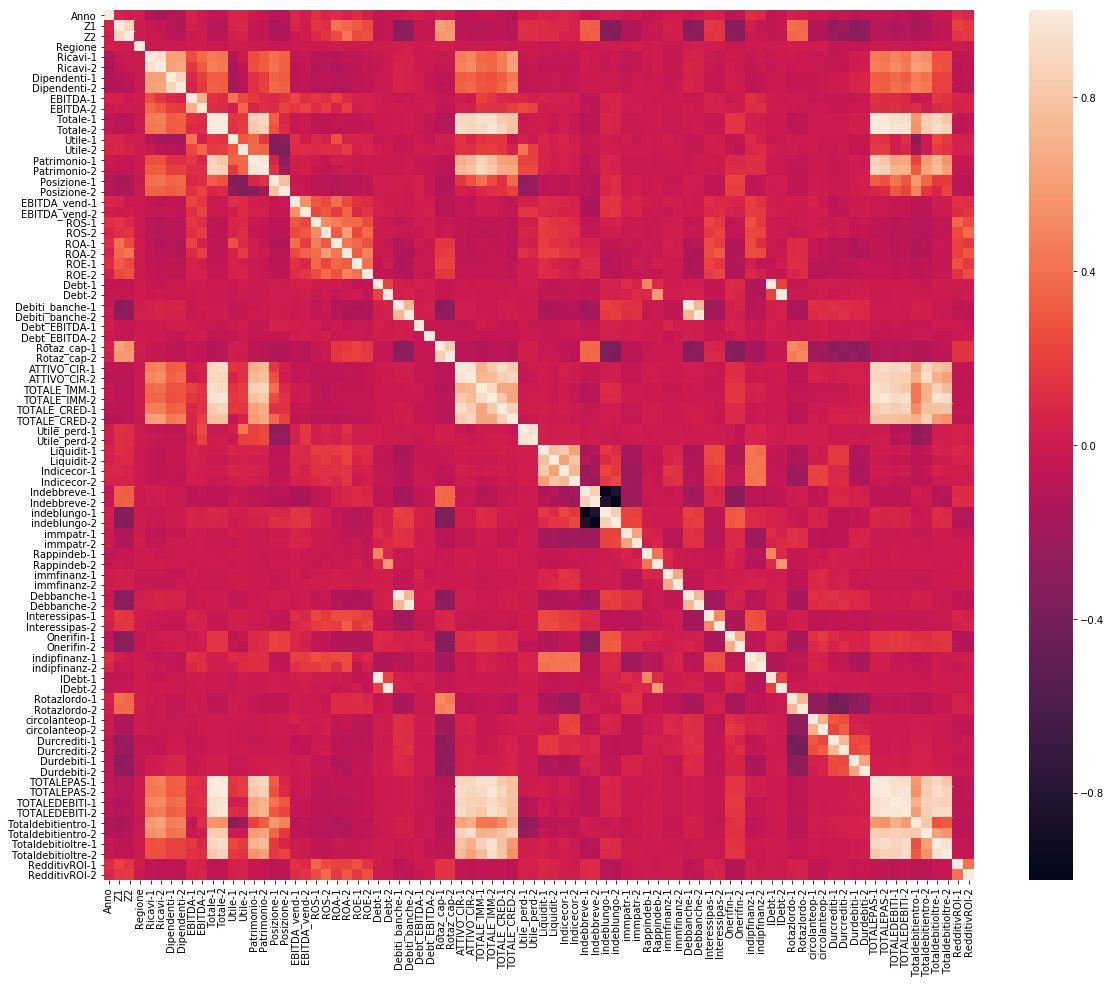

In [21]:
import seaborn
plt.figure(figsize=(20,16))
seaborn.heatmap(Data.corr(), square=True)

Как и следовало ожидать, большинство признаков взаимозависимы, однако исключение данных признаков или понижение размерности посредством методов матричного разложения приводят к некоторой потери данных и сказываются на итоговом качестве. Пока оставим все признаки и попробуем оценить их важность

**Оценка информативности признаков с помощью главных компонент (PCA)**

Можно оценить признаки посредством наложения относительных (классы не сбалансированы) распределений каждого признака с целевой меткой=0 и целевой меткой=1, однако большниство признаков далеки от нормального распределения и хорошо интерпретировать подобную визуализацию не удастся. В силу чего воспользуемся методом главных компонент для анализа внутренних взаимосвязей признаков

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Data[:y.shape[0]].values)
X_scaled = scaler.transform(Data[:y.shape[0]].values)

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

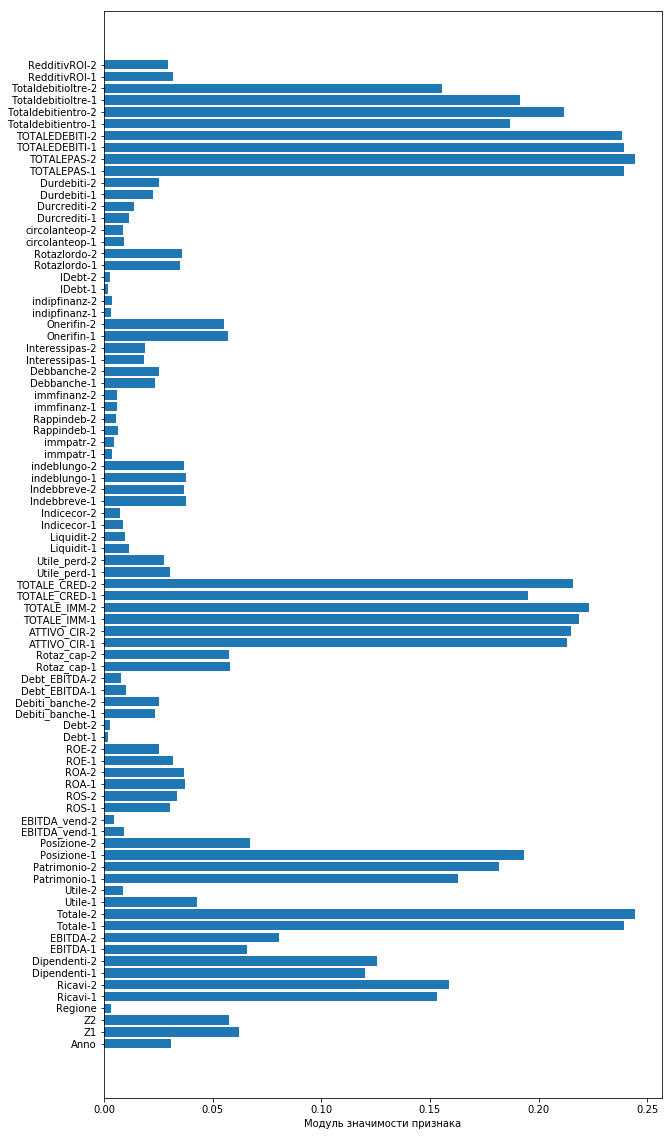

In [24]:
plt.figure(figsize=(10,20))
plt.barh(range(len(pca.components_[0])), abs(pca.components_[0]), alpha=1)
plt.yticks(range(len(pca.components_[0])), data.columns, size=10)
plt.xlabel('Модуль значимости признака', size=10)
plt.show()

**Исследование признаков на Нормальность посредством Q-Q графика**

In [25]:
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

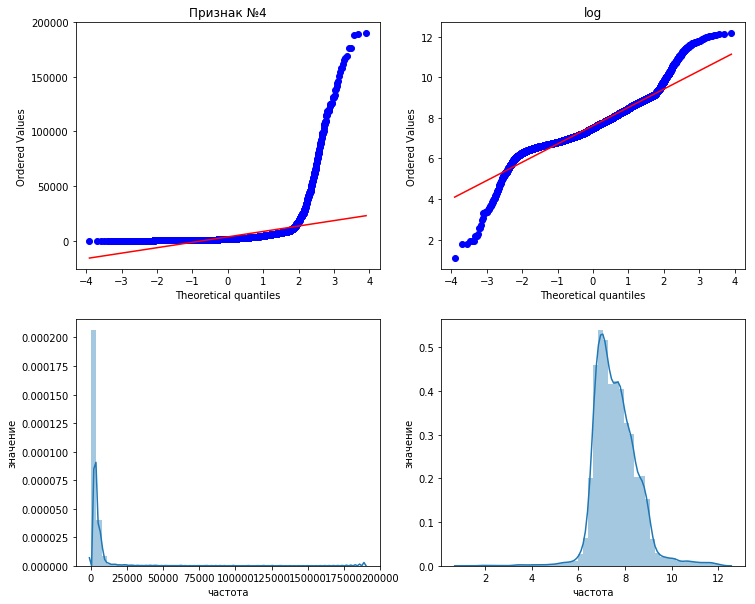

In [30]:
'''Функция построения Q-Q графика и переход к логарифму признака (вывел только признак 4)'''
for i in range(84):
#     Norm_log_QQ_Plot(Data[Data.columns[i]],i)
    if i==4: Norm_log_QQ_Plot(Data[Data.columns[i]],i)

Были выбраны следующие номера признаков, подлежащие логарифмированию:

In [26]:
Columns_lg = [4,5,6,7,10,11,28,29,32,33,34,35,36,37,38,39,42,43,44,45,
              54,55,56,57,58,59,60,61,66,67,70,71,74,75,76,77,78,79,80,81]

In [27]:
'''Логорифмирование данных признаков'''
for i in range(len(Data.columns)):
    if i in Columns_lg:
        mini = Data[Data.columns[i]].min()
        Data[Data.columns[i]] = Data[Data.columns[i]].apply(lambda x: np.log(x+abs(mini)+1))

In [28]:
# Data.head()

**Разбивка выборки на обучение и тест**

In [29]:
X = Data[:y.shape[0]].values
X_test = Data[y.shape[0]:].values
print('Размер обучающей выборки: {}, тестовой выборки: {}'.format(X.shape, X_test.shape))

Размер обучающей выборки: (11000, 84), тестовой выборки: (3966, 84)


In [30]:
'''Перемешаем обучающую выборку'''
from sklearn.utils import shuffle
X,y = shuffle(X,y)

In [31]:
Data = None

### 2. Построение модели Логистической регрессии <a class='anchor' id='2'></a>
[в начало](#0)

In [32]:
from sklearn.model_selection  import cross_val_score, GridSearchCV
from sklearn import pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler

In [249]:
model_1 = LogisticRegression(random_state = 0, class_weight='balanced')

pip_11 = pipeline.Pipeline([('scaler',MinMaxScaler()),('model',model_1)])
pip_12 = pipeline.Pipeline([('scaler',StandardScaler()),('model',model_1)])

In [35]:
%%time
cv = cross_val_score(pip_11, X, y, scoring='roc_auc', cv=5) # предобработка - масштабирование
print('mean:{:.5f}, std:{:.5f}'.format(cv.mean(), cv.std()))

mean:0.96980, std:0.00375
Wall time: 2.52 s


In [36]:
%%time
cv = cross_val_score(pip_12, X, y, scoring='roc_auc', cv=5) # предобработка - стандартизация
print('mean:{:.5f}, std:{:.5f}'.format(cv.mean(), cv.std()))

mean:0.96656, std:0.00531
Wall time: 5.58 s


In [37]:
%%time
pip_11.fit(X,y)
pip_12.fit(X,y)

Wall time: 2.3 s


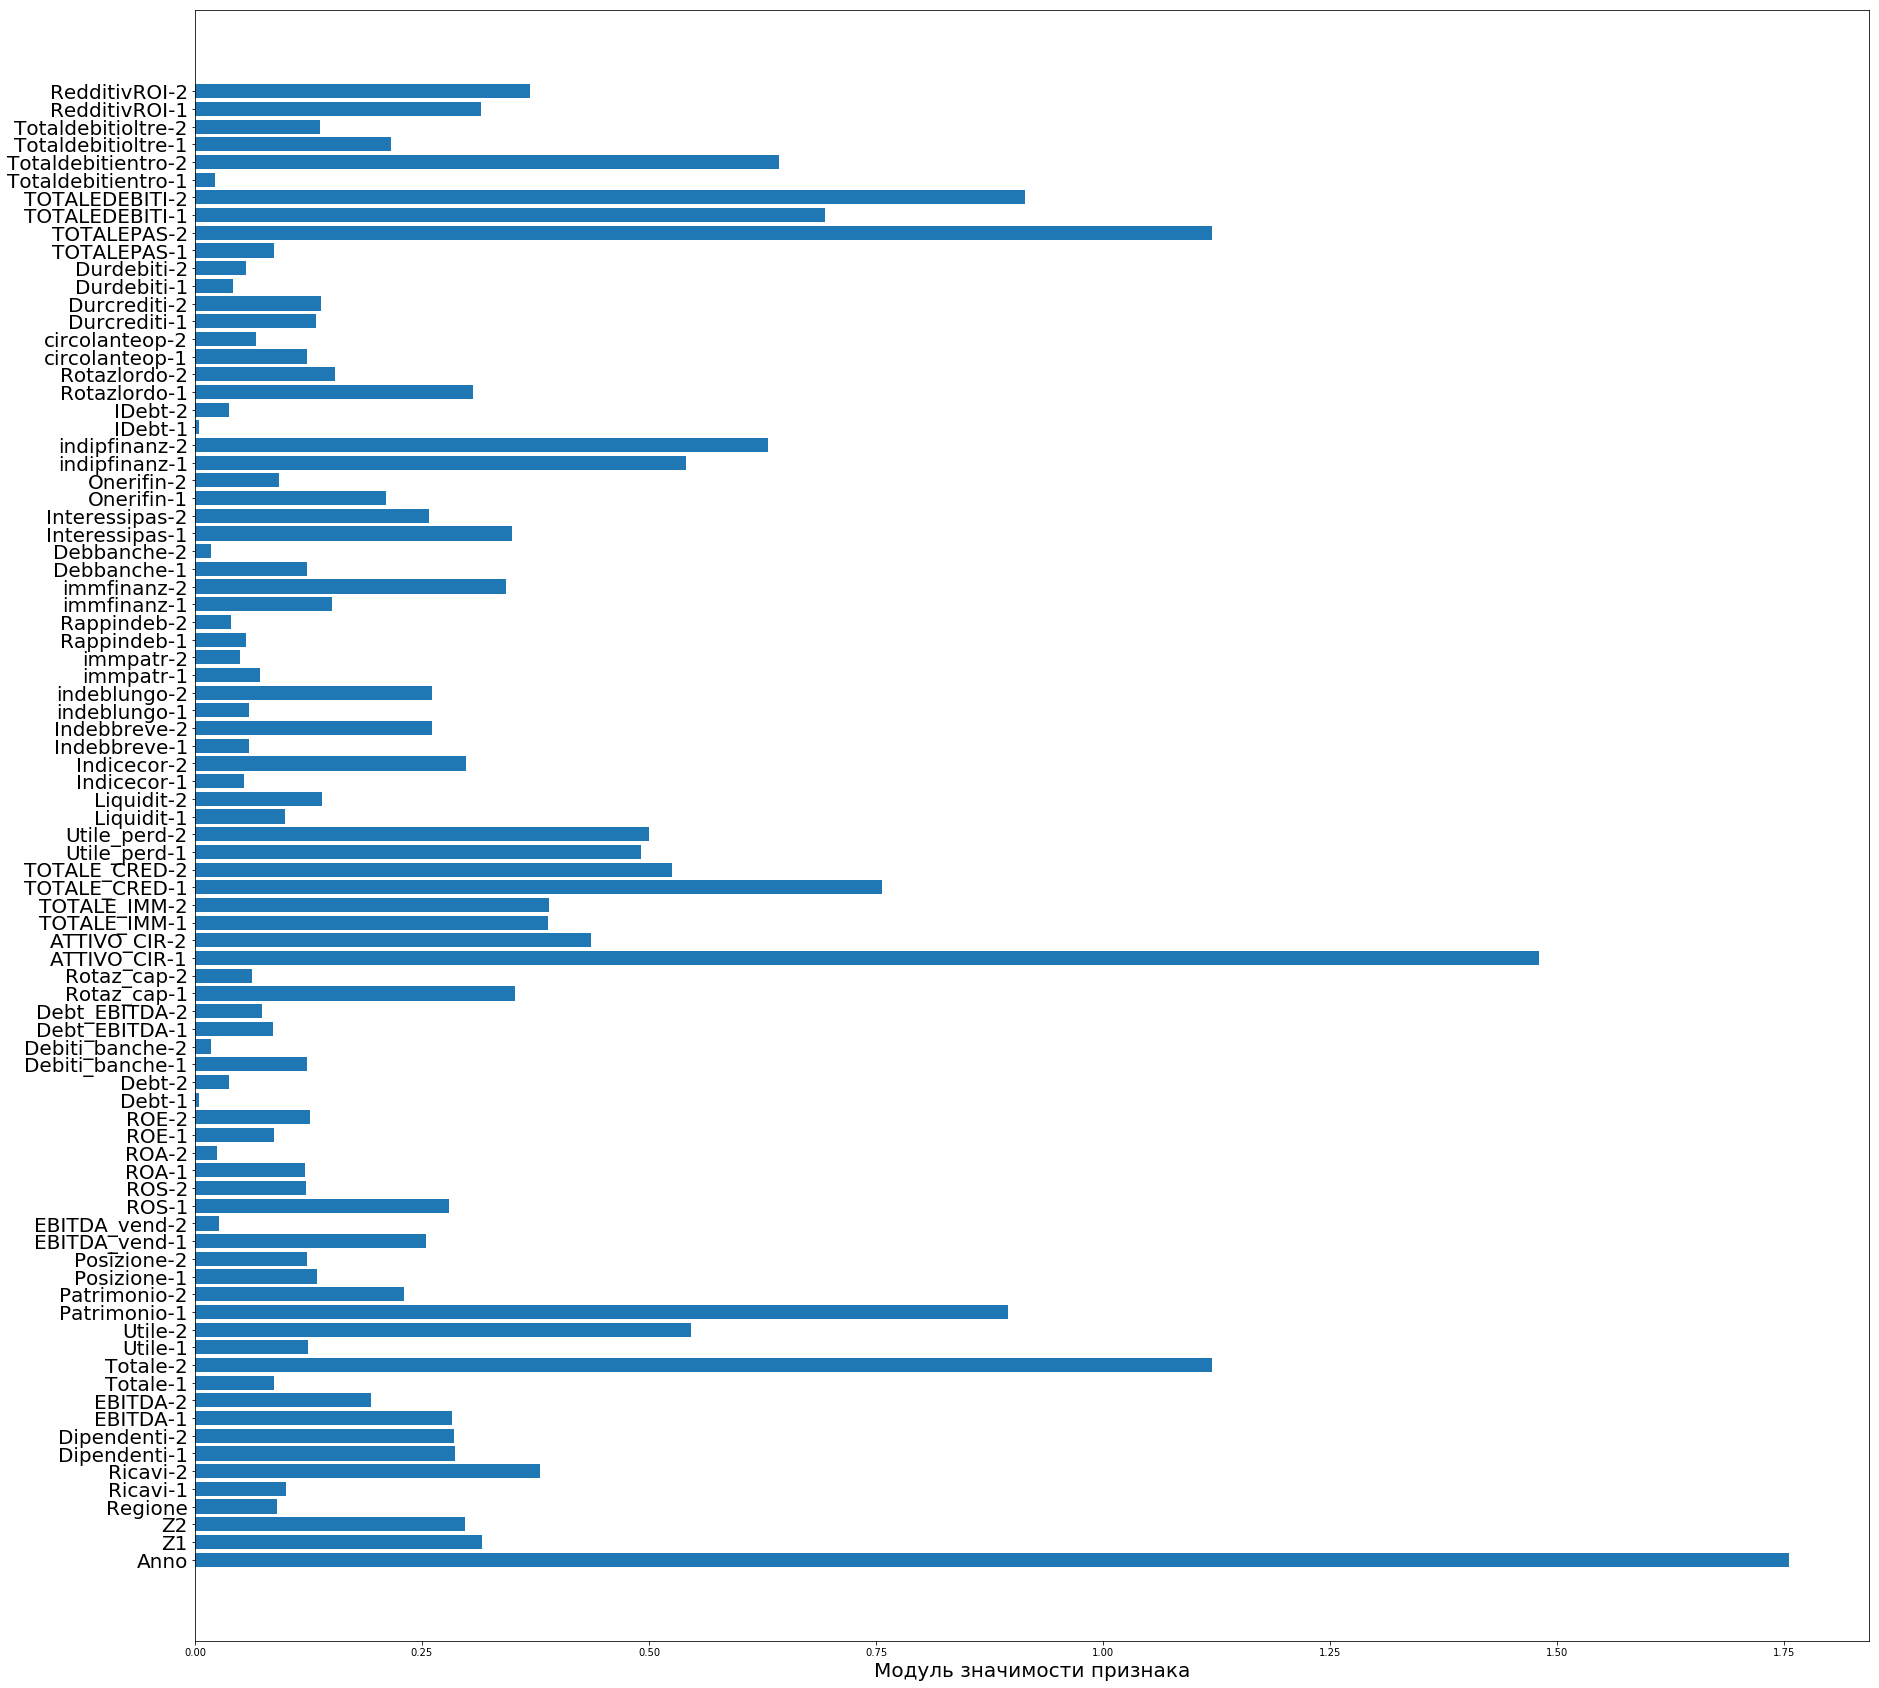

In [40]:
'''построение графика коээфициентов модели'''
PltCoefModel(pip_11)

**Подбор параметров по сетке**

In [41]:
param_grid = {'model__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'model__penalty': ['l1','l2']}
grid_11 = GridSearchCV(pip_11, param_grid, scoring='roc_auc', cv=5)
grid_12 = GridSearchCV(pip_12, param_grid, scoring='roc_auc', cv=5)

In [42]:
%%time
grid_11.fit(X,y)
grid_12.fit(X,y)

Wall time: 1h 4min 25s


In [43]:
print('Лучшая оценка с масштабированием признаков: ',grid_11.best_score_, 'параметры:', grid_11.best_params_)
print('Лучшая оценка со стандартизацией признаков: ',grid_12.best_score_, 'параметры:', grid_11.best_params_)

Лучшая оценка с масштабированием признаков:  0.97016760389 параметры: {'model__C': 1, 'model__penalty': 'l1'}
Лучшая оценка со стандартизацией признаков:  0.970807717965 параметры: {'model__C': 1, 'model__penalty': 'l1'}


### 3. Построение модели Ядерного метода опрных векторов <a class='anchor' id='3'></a>
[в начало](#0)

In [251]:
from sklearn.svm import LinearSVC, SVC

In [252]:
model_2 = LinearSVC(random_state = 0, class_weight='balanced')

pip_21 = pipeline.Pipeline([('scaler',MinMaxScaler()),('model',model_2)])
pip_22 = pipeline.Pipeline([('scaler',StandardScaler()),('model',model_2)])

In [44]:
%%time
cv = cross_val_score(pip_21, X, y, scoring='roc_auc',cv=5) # предобработка - масштабирование
print('mean:{:.5f}, std:{:.5f}'.format(cv.mean(), cv.std()))

mean:0.97143, std:0.00581
Wall time: 26.4 s


In [45]:
%%time
cv = cross_val_score(pip_22, X, y, scoring='roc_auc',cv=5) # предобработка - стандартизация
print('mean:{:.5f}, std:{:.5f}'.format(cv.mean(), cv.std()))

mean:0.96653, std:0.01006
Wall time: 28.4 s


In [77]:
%%time
pip_21.fit(X,y)
pip_22.fit(X,y)

Wall time: 14.7 s


**Попробуем SVM с нелинейным ядром:**

In [96]:
model_3 = SVC(random_state = 0, class_weight='balanced')

pip_3 = pipeline.Pipeline([('scaler',MinMaxScaler()),('model',model_3)])

In [79]:
%%time
cv = cross_val_score(pip_3, X, y, scoring='roc_auc',cv=5)
print('mean:{:.5f}, std:{:.5f}'.format(cv.mean(), cv.std()))

mean:0.96820, std:0.00527
Wall time: 51.7 s


Качество хуже чем линейный SVM, однако попробуем подобрать параметры по сетке:

**Подбор параметров по сетке**

In [87]:
'''оптимизационные параметры в сетке'''
param_grid = {'model__C': [0.1, 1, 10, 50, 100, 150],  'model__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_3 = GridSearchCV(pip_3, param_grid, scoring='roc_auc', cv=5) # сетка

In [88]:
%%time
grid_3.fit(X,y)
print()


Wall time: 1h 48min 9s


Построим график подбора параметров по сетке:

C:\Users\Dima\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


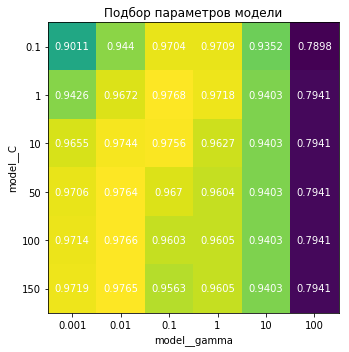

In [138]:
'''визуализация параметров модели по сетке'''
PrintGridParams(grid_3, param_grid=param_grid, param_2='model__C', param_1='model__gamma', color='w')

In [142]:
grid_3.best_params_

{'model__C': 1, 'model__gamma': 0.1}

In [143]:
grid_3.best_score_

0.97683505025836148

In [259]:
%%time
model_3 = SVC(random_state = 0, class_weight='balanced', C=1, gamma=0.1)
pip_3 = pipeline.Pipeline([('scaler',MinMaxScaler()),('model',model_3)])
pip_3.fit(X,y)

Wall time: 4.98 s


Качество SVM с нелинейным ядром чуть лучше линейных моделей. Попробуем модели ансамбли

### 4. Построение модели Случайный лес <a class='anchor' id='4'></a>
[в начало](#0)

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [254]:
model_41 = RandomForestClassifier(random_state=0, n_estimators=100)
model_42 = RandomForestClassifier(random_state=0, n_estimators=1000)

Отмечу, что **ансамбли нейтрально отностяся к машстабированию**, в отличии от линейных моделей и методов опорных векторов

In [35]:
%%time
cv = cross_val_score(model_41, X, y, scoring='roc_auc', cv=5)
print('mean:{:.5f}, std:{:.5f}'.format(cv.mean(), cv.std()))

mean:0.97860, std:0.00658
Wall time: 1min 6s


In [38]:
%%time
cv = cross_val_score(model_42, X, y, scoring='roc_auc', cv=5)
print('mean:{:.5f}, std:{:.5f}'.format(cv.mean(), cv.std()))

mean:0.98020, std:0.00672
Wall time: 10min 39s


**Попробуем подобрать параметры для случайного леса с большим количеством деревьев (это позволит снизить Std на кросс-валидации)**

In [25]:
param_grid = {'max_features': ['auto']+list(np.arange(2,52,2)), 
              'max_depth': [None,15]
              }
clf = RandomForestClassifier(random_state=10, n_estimators=5000, oob_score=False)
grid_forest = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=5, n_jobs=3)

In [26]:
%%time
grid_forest.fit(X,y)

Wall time: 17h 31min 1s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'max_features': ['auto', 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50], 'max_depth': [None, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [25]:
'''Сохраним полученную модель-сетку'''
from sklearn.externals import joblib
Grid = joblib.load("./Model_Grid_Forest.pkl")

In [26]:
Grid.best_score_

0.98169201465819722

Посредством увеличения количества деревьев можно выйти на качество в 0.98, однако тогда, подбор параметров потребует слишком большого количества времени, я сделаю акцент на градиентном бустинге (xgboost)

### 5. Построение модели Градиентный бустинг <a class='anchor' id='5'></a>
[в начало](#0)

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [41]:
model_5 = GradientBoostingClassifier(random_state=0, n_estimators=300, learning_rate=0.033)
# скорость обучения опустил в силу пропорционального увеличения числа деревьев множитель=3

In [42]:
%%time
cv = cross_val_score(model_5, X, y, scoring='roc_auc', cv=5)
print('mean:{:.5f}, std:{:.5f}'.format(cv.mean(), cv.std()))

mean:0.98035, std:0.00700
Wall time: 3min 35s


Градиентный бустинг от xgboost в среднем в два раза быстрее, однако параметры мне удобнее подбирать в sklearn

Начнем с подбора скорости обучения и числа деревьев (возьмем немного деревьев для скорости, потом увеличим), затем перейдем к параметрам деревьев (базовых алгоритмов). Я не буду использовать сетку сразу по всем параметрам, а буду последовательно подбирать.

**Оптимальная скорость обучения при 500 деревьев**

In [162]:
%%time
learning_rate = np.arange(0.0001,0.1,0.002)
scoring_learning_rate = []
std_learning_rate = []

for i in learning_rate:
    clf = GradientBoostingClassifier(n_estimators=500, learning_rate=i, random_state=10)
    cv = cross_val_score(clf, X, y, scoring='roc_auc', cv=5)
    scoring_learning_rate.append(cv.mean())
    std_learning_rate.append(cv.std())

Wall time: 2h 5min 51s


Лучшая скорость: 0.0261


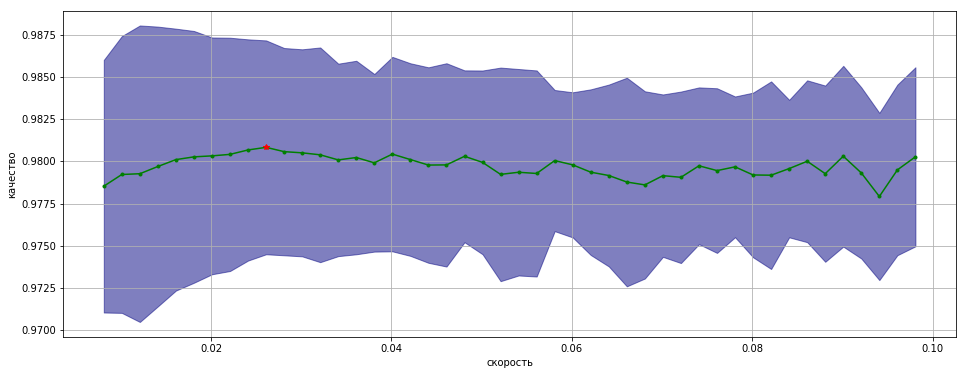

In [164]:
# plot_score_params('Лучшая скорость:', 'скорость', learning_rate, scoring_learning_rate, std_learning_rate)
plot_score_params('Лучшая скорость:', 'скорость', learning_rate[4:], scoring_learning_rate[4:], std_learning_rate[4:])

**Глубина и Минимальное число объектов в каждом узле**

In [173]:
%%time
max_depth = np.arange(4,16,2)
min_samples_split = np.arange(500,1100,100)

param_grid = {'max_depth': max_depth, 'min_samples_split': min_samples_split}
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.0261, random_state=10)
grid = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid.fit(X,y)

Wall time: 2h 31min 17s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


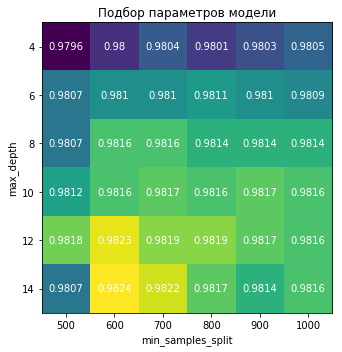

In [202]:
'''визуализация параметров модели по сетке'''
PrintGridParams(grid, param_grid=param_grid, param_1='max_depth', param_2='min_samples_split', color='w')

Рассмотрим более подробно левый нижний угол квадрата:

In [203]:
%%time
max_depth = np.arange(10,20,1)
min_samples_split = np.arange(500,825,25)

param_grid = {'max_depth': max_depth, 'min_samples_split': min_samples_split}
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.0261, random_state=10)
grid = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid.fit(X,y)

Wall time: 14h 11min 40s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


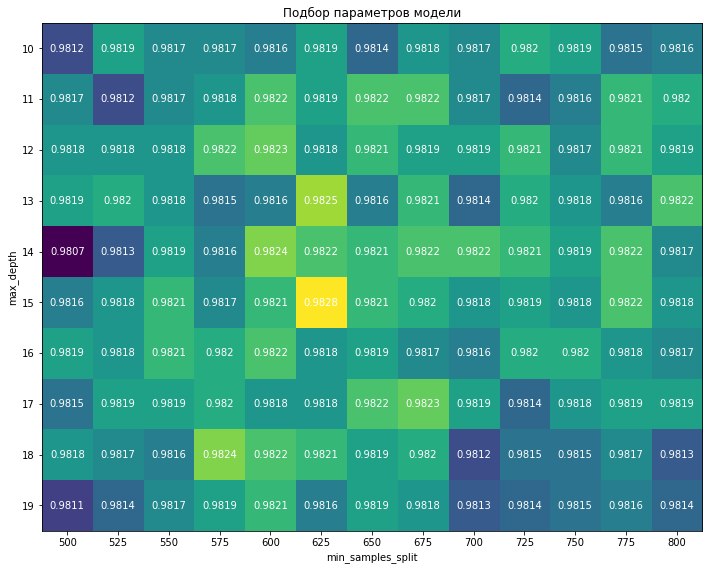

In [209]:
'''визуализация параметров модели по сетке'''
PrintGridParams(grid, param_grid=param_grid, param_1='max_depth', param_2='min_samples_split', color='w', size=(10,10))

**Минимальное число объектов в листьях**

In [232]:
%%time
min_samples_leaf = [1]+list(np.arange(10,110,10))
scoring_min_samples_leaf = []
std_min_samples_leaf = []

for i in min_samples_leaf:
    clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.0261, max_depth=15, min_samples_split=625,
                                     min_samples_leaf=i, random_state=10)
    cv = cross_val_score(clf, X, y, scoring='roc_auc', cv=5)
    scoring_min_samples_leaf.append(cv.mean())
    std_min_samples_leaf.append(cv.std())

Wall time: 1h 55min 40s


Лучшее минимальное число объектов в листе: 1


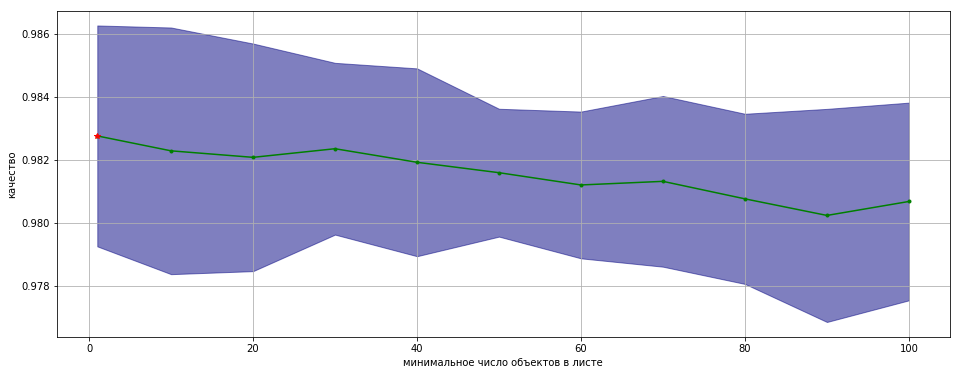

In [233]:
plot_score_params('Лучшее минимальное число объектов в листе:', 'минимальное число объектов в листе', 
                  min_samples_leaf, scoring_min_samples_leaf, std_min_samples_leaf)

**Максимальное число признаков на дерево**

In [234]:
%%time
max_features = range(2,30,2)
scoring_max_features = []
std_max_features = []

for i in max_features:
    clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.0261, max_depth=15, min_samples_split=625,
                                     min_samples_leaf=1, max_features=i, random_state=10)
    cv = cross_val_score(clf, X, y, scoring='roc_auc', cv=5)
    scoring_max_features.append(cv.mean())
    std_max_features.append(cv.std())

Wall time: 31min 43s


Лучшее максимальное число признаков на дерево: 12


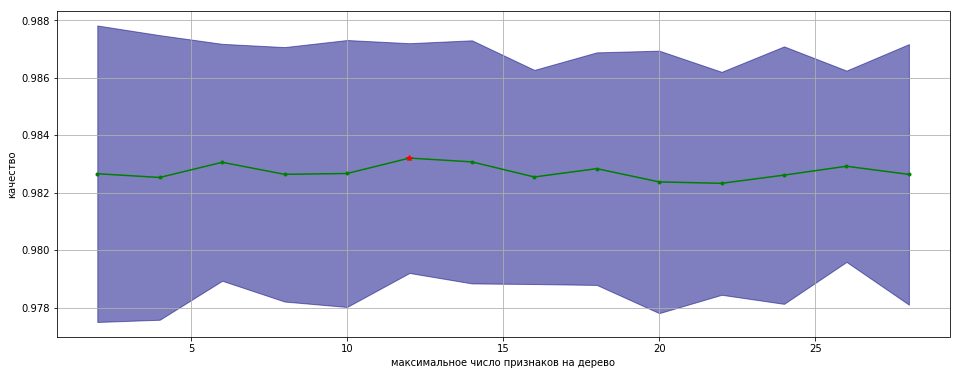

In [235]:
plot_score_params('Лучшее максимальное число признаков на дерево:', 'максимальное число признаков на дерево', 
                  max_features, scoring_max_features, std_max_features)

**Отношение подвыборок на обучении**

In [239]:
%%time
subsample = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
scoring_subsample = []
std_subsample = []

for i in subsample:
    clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.0261, max_depth=15, min_samples_split=625,
                                     min_samples_leaf=1, max_features=12, subsample=i, random_state=10)
    cv = cross_val_score(clf, X, y, scoring='roc_auc', cv=5)
    scoring_subsample.append(cv.mean())
    std_subsample.append(cv.std())

Wall time: 9min 7s


Лучшее отношение подвыборок на обучении: 1.0


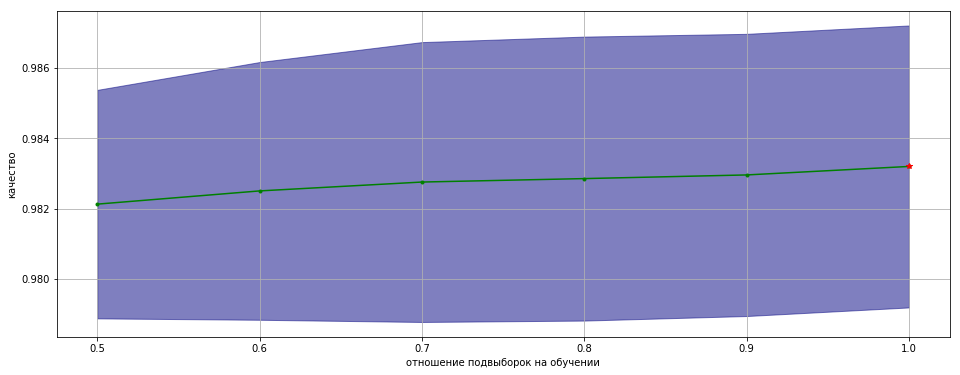

In [240]:
plot_score_params('Лучшее отношение подвыборок на обучении:', 'отношение подвыборок на обучении', 
                  subsample, scoring_subsample, std_subsample)

**Увеличение деревьев при пропорциональном снижении скорости обучения**

Теперь можно увеличить количество деревьев, но при этом нужно пропорционально снизить скорость обучения. Предаполагаю, что увеличение количества деревьев способствует уменьшению Std на кросс-валидации и возможно увеличит оценку

In [243]:
%%time
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.0261, max_depth=15, min_samples_split=625,
                                 min_samples_leaf=1, max_features=12, subsample=1, random_state=10)
cv = cross_val_score(clf, X, y, scoring='roc_auc', cv=5)
print('500 деревьев. mean:{:.5f}, std:{:.5f}'.format(cv.mean(), cv.std()))

500 деревьев. mean:0.98321, std:0.00400
Wall time: 1min 51s


In [245]:
%%time
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01305, max_depth=15, min_samples_split=625,
                                 min_samples_leaf=1, max_features=12, subsample=1, random_state=10)
cv = cross_val_score(clf, X, y, scoring='roc_auc', cv=5)
print('1000 деревьев. mean:{:.5f}, std:{:.5f}'.format(cv.mean(), cv.std()))

1000 деревьев. mean:0.98347, std:0.00381
Wall time: 3min 39s


In [246]:
%%time
clf = GradientBoostingClassifier(n_estimators=5000, learning_rate=0.00261, max_depth=15, min_samples_split=625,
                                 min_samples_leaf=1, max_features=12, subsample=1, random_state=10)
cv = cross_val_score(clf, X, y, scoring='roc_auc', cv=5)
print('5000 деревьев. mean:{:.5f}, std:{:.5f}'.format(cv.mean(), cv.std()))

5000 деревьев. mean:0.98334, std:0.00392
Wall time: 18min 20s


Оптимально выбрать градиентный бустинг с 1000 деревьями

In [248]:
model_5 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01305, max_depth=15, min_samples_split=625,
                                     min_samples_leaf=1, max_features=12, subsample=1, random_state=10)

### 6.  Сравнение ROC кривых<a class='anchor' id='6'></a>
[в начало](#0)

In [35]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [36]:
'''Разобьем выборку на обучение и тест в отношении 70к30'''
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

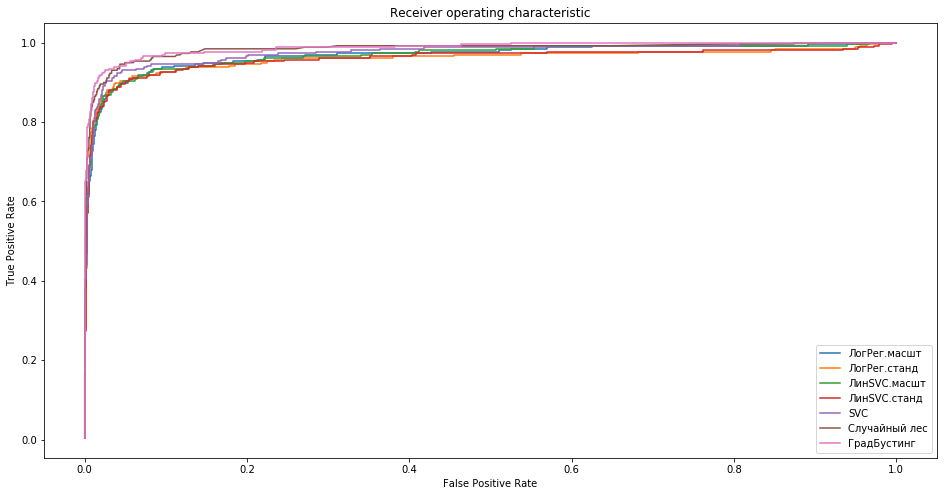

In [260]:
models = [pip_11, pip_12, pip_21, pip_22, pip_3, model_42, model_5]
str_models = ['ЛогРег.масшт', 'ЛогРег.станд', 'ЛинSVC.масшт', 'ЛинSVC.станд', 'SVC', 
              'Случайный лес', 'ГрадБустинг']

plt.figure(figsize=(16, 8)) 
for model, str_model in zip(models,str_models):
    model.fit(X_train, y_train)
    if (str_model in ['ЛинSVC.масшт', 'ЛинSVC.станд', 'SVC']):
        pred_scr = model.decision_function(X_valid)
    else:
        pred_scr = model.predict_proba(X_valid)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_valid, pred_scr)
    plt.plot(fpr, tpr, label=str_model)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Выберем в качестве итоговой модели Градиентный бустинг для которого мы подобрали параметры

### 7. Получение прогнозов на тесте <a class='anchor' id='7'></a>
[в начало](#0)

In [46]:
Model = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01305, max_depth=15, min_samples_split=625,
                                   min_samples_leaf=1, max_features=12, subsample=1, random_state=10)
# Model = RandomForestClassifier(n_estimators=5000, max_features=15) # случаный лес на 5к деревьев
Model.fit(X,y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01305, loss='deviance', max_depth=15,
              max_features=12, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=625,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=10, subsample=1, verbose=0,
              warm_start=False)

In [49]:
test_predict = Model.predict_proba(X_test)[:, 1]

**Подгрузка результатов**

In [50]:
Test = pd.read_csv('sample.csv', sep=';')
Test.head()

,ID,Target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [51]:
Test['Target'] = test_predict

In [52]:
Test.head()

,ID,Target
0,1,0.000535
1,2,0.000998
2,3,0.001351
3,4,0.000319
4,5,0.008343


In [53]:
Test.to_csv('ADN_XGB_TEST.csv', sep=',', index=False)
print(Test.shape)

(3966, 2)


### 8. Пользовательские функции <a class='anchor' id='8'></a>                                                
[в начало](#0)

In [175]:
'''Функция преобразование строковочисловых признаков в численные'''
def ReplaceNumericData(x, columns):
    for c in columns:
        x[c] = x[c].apply(lambda x: x.replace(' ', '')) # удаление пробелов
        x[c] = x[c].apply(pd.to_numeric) # преобразование в число

In [176]:
'''функция построения графика коэффициентов модели'''
def PltCoefModel(pipeline,x=30,y=30):
    plt.figure(figsize=(x,y))
    plt.barh(range(len(Data.columns)), abs(pipeline.named_steps['model'].coef_[0]), align='center')
    plt.yticks(range(len(Data.columns)), Data.columns, size=20)
    plt.xlabel('Модуль значимости признака', size=20)
    plt.show()

In [205]:
'''функция визуализации параметров модели по сетке'''
def PrintGridParams(grid, param_grid, param_1, param_2, color='b', size=(10,10)):

    values = grid.grid_scores_
    values = [values[k][1] for k in range(len(values))]
    values = np.round(values,4)
    size_1 = len(param_grid[param_1]) 
    size_2 = len(param_grid[param_2])
    values = np.reshape(values,(size_1,size_2)) # преобразование списка в матрицу

    xx = param_grid[param_2]
    yy = param_grid[param_1]
    
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(values)

    ax.set_xticks(range(len(xx)))
    ax.set_yticks(range(len(yy)))
    ax.set_xticklabels(xx)
    ax.set_yticklabels(yy)
    ax.set_xlabel(param_2)
    ax.set_ylabel(param_1)
    
    for i in range(len(xx)):
        for j in range(len(yy)):
            text = ax.text(i, j, values[j,i], ha='center', va='center', color=color)

    ax.set_title('Подбор параметров модели')
    fig.tight_layout()
    plt.show()

In [178]:
'''Функция построения Q-Q графика и переход к логорифму признака'''
def Norm_log_QQ_Plot(df,k):
    plt.figure(figsize=(12,10))
    plt.subplot(2,2,1)
    stats.probplot(df, dist="norm", plot=plt) # Q-Q график для income 
    plt.title('Признак №'+str(k))
    plt.subplot(2,2,2)
    stats.probplot(np.log(df+abs(df.min())+1), dist="norm", plot=plt) # Q-Q график для age
    plt.title('log')
    plt.subplot(2,2,3)
#     plt.hist(df, color='red')
    seaborn.distplot(df.dropna(),bins=50)
    # plt.title('доход')
    plt.xlabel('частота')
    plt.ylabel('значение')
    plt.subplot(2,2,4)
#     plt.hist(np.log(df+abs(df.min())+1), color='green')
    seaborn.distplot(np.log(df+abs(df.min())+1).dropna(),bins=50)
#     plt.title(str(k))
    plt.xlabel('частота')
    plt.ylabel('значение')
    plt.show()

In [115]:
'''Построение кривых по параметрам'''
def plot_score_params(string, string_x, n, score, std):
    print(string,n[np.argmax(score)])

    std_1 = np.array(score)-np.array(std)
    std_2 = np.array(score)+np.array(std)

    plt.figure(figsize=(16,6))
    plt.plot(n, score, marker='.', color='green')
    plt.fill_between(n, std_1, std_2, color='navy', alpha=0.5)
    plt.plot(n[np.argmax(score)], max(score), color='red', marker='*')
    plt.grid(True)
    plt.xlabel(string_x)
    plt.ylabel('качество')
    plt.show()

### 9. Идеи не получившие должного качества <a class='anchor' id='9'></a>
[в начало](#0)

**Создание новых признаков посредством Кластеризации и методов понижения размерности (PCA, t-SNE)**

In [675]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN

In [627]:
%%time
tsne = TSNE()
Data_tsne = tsne.fit_transform(Data)

Wall time: 23min 24s


Text(0.5,0,'t-SNE признак 1')

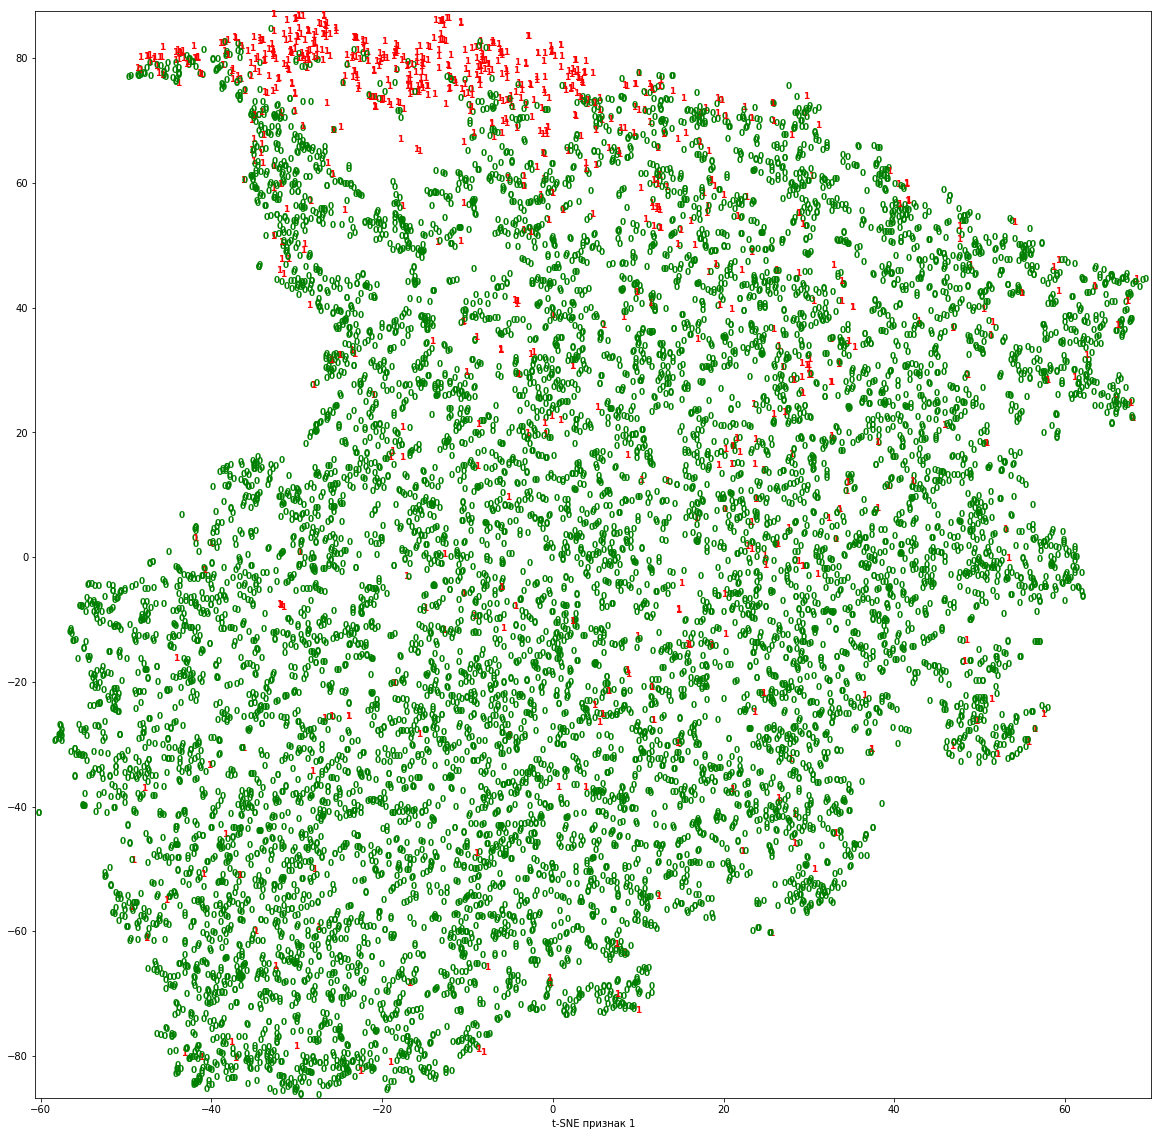

In [635]:
colors = ['green', 'red']
plt.figure(figsize=(20, 20))
plt.xlim(Data_tsne[:11000, 0].min(), Data_tsne[:11000, 0].max() + 1)
plt.ylim(Data_tsne[:11000, 1].min(), Data_tsne[:11000, 1].max() + 1)
for i in range(len(y)):
    # строим график, где цифры представлены символами вместо точек
    plt.text(Data_tsne[i, 0], Data_tsne[i, 1], str(y[i]),
            color = colors[y[i]],
            fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE признак 0")
plt.xlabel("t-SNE признак 1")

TSNE нам не поможет, т.к. класстеры неразделимы в двухмерном пространстве. Попробуем PCA а затем применим кластеризацию:

In [746]:
'''сначало произведем масштабирование признаков'''
minmax = MinMaxScaler()
Data_scal = minmax.fit_transform(Data)

'''генерация новых признаков посредством PCA и kMeans'''
for i in [2,3,5,10,15,20]:
    for j in [2,4,10,20]:
        pca = PCA(n_components=i)
        Data_pca = pca.fit_transform(Data_scal)
        kmeans = KMeans(n_clusters=j)
        clusters = kmeans.fit_predict(Data_pca)
        Data['clusters_'+str(i)+'_'+str(j)] = clusters

In [747]:
Data.head()

,Anno,Z1,Z2,Regione,Ricavi-1,Ricavi-2,Dipendenti-1,Dipendenti-2,EBITDA-1,EBITDA-2,...,clusters_10_10,clusters_10_20,clusters_15_2,clusters_15_4,clusters_15_10,clusters_15_20,clusters_20_2,clusters_20_4,clusters_20_10,clusters_20_20
0,2016,1.479190,1.695080,24,3618,3337,26,24,-371,-64,...,6,0,0,1,1,2,0,1,1,18
1,2016,1.547276,1.721152,19,1735,1843,2,2,281,433,...,6,15,0,1,1,4,0,1,1,4
2,2016,1.102310,1.526099,3,1098,1166,10,13,93,56,...,4,13,1,0,9,19,1,2,7,10
3,2016,3.824231,3.456398,17,9187,9081,44,45,362,315,...,4,9,1,2,9,0,1,3,7,14
4,2016,3.082321,2.647675,15,2712,2426,14,13,113,125,...,6,10,0,1,1,1,0,1,1,9


**Анализ признаков не подлежащий логарифмированию (Дискретизация)**

In [37]:
'''Выбор множества признаков для дискретизации'''
Columns_not_lg = set(range(84))
Columns_not_lg = Columns_not_lg.difference(Columns_lg) # разность множеств
Columns_not_lg = Columns_not_lg.difference([0,3,20,21,24,25,46,47,62,63,72,73,82,83])

In [38]:
'''Дискретизация выбранных признаков'''
for i in Columns_not_lg:
    Max = Data[Data.columns[i]].max()
    Min = Data[Data.columns[i]].min()
    Mean = Data[Data.columns[i]].mean()
    if Min==0: Min=0.000000000001
    r = np.geomspace(Mean,Max,50)
    l = np.geomspace(Mean,abs(Min),50)
    if Min<0: l=-l
    bins = np.concatenate((np.sort(l),r))
    Data[Data.columns[i]] = np.digitize(Data[Data.columns[i]], bins=bins)

In [40]:
Data.head()

### [в начало](#0)